<p style="font-family: helvetica,arial,sans-serif; font-size:2.0em;color:white; background-color: black;">&emsp;<b>EDA: Compare Pedestrian Traffic Day and Night</b></p>
    
<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:black; background-color: #DDDDDD; text-align:justify">&emsp;<b>Authored by: </b> Barkha Javed</p>

<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:white; background-color: black; text-align:right"> <b>Duration:</b> 45 mins&emsp;</p>

<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:black; background-color: #DDDDDD; text-align:justify">&emsp;<b>Level: </b>Beginner&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;<b>Pre-requisite Skills:</b>Python</p>

<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:white; background-color: black">&emsp;<b>Scenario</b>

# Business & Activity 
As a small business owner, I want to understand how covid affected foot traffic, and how long it might take to return to normal. I'd also like deeper insights into how different activities can impact pedestrian traffic.

 Factors impacting traffic include those listed below, we will be examining some of these in depth:
- Seasonality through temperature, severe weather events,  daylight savings, public holidays such as Christmas, school holidays, 
- Time of day, day of week
- Major events such as the AFL, concerts and exhibitions
- Proximity to public transport: Trains / Buses / Trams
- Number of local residences
- Number of people travelling into the CBD
- Covid cases and status
- Other venues in proximity - schools, universities, parks, retail outlets, restaurants, bars, clubs, cinemas

This exploratory data analysis looks at <b><i>Time of day, day of week impact on foot traffic</i></b>.

## Data Preparation

In [74]:
# pip -q is to give less output
!pip -q install sodapy
!pip -q install seaborn
!pip -q install pandas
!pip -q install matplotlib
!pip -q install numpy
!pip -q install nbconvert
!pip -q install keyboard

In [63]:
#load libraries
import pandas as pd
import numpy as np
import requests
import io
import keyboard
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from sodapy import Socrata

import warnings
warnings.filterwarnings('ignore')

### Data Acquisition Pedestrian Sensor Locations

In [64]:
#Location data
client = Socrata('data.melbourne.vic.gov.au', '9UAGAvkem9fqXDhBLElapjazL', None)
sensor_data_id = "h57g-5234"
results = client.get(sensor_data_id)
sensor_location = pd.DataFrame.from_records(results)
#sensor_location.head(5)

sensor_location[['latitude', 'longitude']] = sensor_location[['latitude', 'longitude']].astype(float)
sensor_location = sensor_location.drop('location',axis=1)

#View sensor data
sensor_location.info()
sensor_location.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sensor_id           91 non-null     object 
 1   sensor_description  91 non-null     object 
 2   sensor_name         91 non-null     object 
 3   installation_date   91 non-null     object 
 4   status              91 non-null     object 
 5   note                10 non-null     object 
 6   latitude            91 non-null     float64
 7   longitude           91 non-null     float64
 8   direction_1         78 non-null     object 
 9   direction_2         78 non-null     object 
dtypes: float64(2), object(8)
memory usage: 7.2+ KB


,sensor_id,sensor_description,sensor_name,installation_date,status,note,latitude,longitude,direction_1,direction_2
0,16,Australia on Collins,Col270_T,2009-03-30T00:00:00.000,R,Device moved to location ID 53 (22/09/2015),-37.815734,144.965210,NaN,NaN
1,50,Faraday St-Lygon St (West),Lyg309_T,2017-11-30T00:00:00.000,A,NaN,-37.798082,144.967210,South,North
2,73,Bourke St - Spencer St (South),Bou655_T,2020-10-02T00:00:00.000,I,NaN,-37.816957,144.954154,East,West
3,66,State Library - New,QVN_T,2020-04-06T00:00:00.000,A,NaN,-37.810578,144.964443,South,North
4,59,Building 80 RMIT,RMIT_T,2019-02-13T00:00:00.000,A,NaN,-37.808256,144.963049,South,North


### Data Acquisition Pedestrian Traffic

In [65]:
##Pedestrian foot count data 
sensor_data_id = "b2ak-trbp"

##Uncomment lines below to open data source, download sensor data, and store it as a csv locally.
#results = client.get(sensor_data_id, limit=7000000)
#ds_traffic = pd.DataFrame.from_records(results)
#ds_traffic.to_csv('sensor_traffic.csv', index=False)

sensor_traffic = pd.read_csv('sensor_traffic.csv')
sensor_traffic.info()

print(f'\nThe shape of dataset is {sensor_traffic.shape}. \n')
print('Below are the first few rows of this dataset: ')
sensor_traffic.head(10)
sensor_traffic['sensor_id']=sensor_traffic['sensor_id'].astype(int)
sensor_location['sensor_id']=sensor_location['sensor_id'].astype(int)

sensor_ds = pd.merge(sensor_traffic, sensor_location, on='sensor_id')
sensor_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4463670 entries, 0 to 4463669
Data columns (total 10 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   id             int64 
 1   date_time      object
 2   year           int64 
 3   month          object
 4   mdate          int64 
 5   day            object
 6   time           int64 
 7   sensor_id      int64 
 8   sensor_name    object
 9   hourly_counts  int64 
dtypes: int64(6), object(4)
memory usage: 340.6+ MB

The shape of dataset is (4463670, 10). 

Below are the first few rows of this dataset: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4463670 entries, 0 to 4463669
Data columns (total 11 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   id             int64 
 1   date_time      object
 2   year           int64 
 3   month          object
 4   mdate          int64 
 5   day            object
 6   time           int64 
 7   sensor_id      int32 
 8   sensor_name    object
 9   hourly_

In [68]:
#Add date column
sensor_traffic['date'] = pd.to_datetime(sensor_history.date_time).dt.date
sensor_traffic.head(10)

,id,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts,date
0,2887628,2019-11-01T17:00:00.000,2019,November,1,Friday,17,34,Flinders St-Spark La,300,2019-11-01
1,2887629,2019-11-01T17:00:00.000,2019,November,1,Friday,17,39,Alfred Place,604,2019-11-01
2,2887630,2019-11-01T17:00:00.000,2019,November,1,Friday,17,37,Lygon St (East),216,2019-11-01
3,2887631,2019-11-01T17:00:00.000,2019,November,1,Friday,17,40,Lonsdale St-Spring St (West),627,2019-11-01
4,2887632,2019-11-01T17:00:00.000,2019,November,1,Friday,17,36,Queen St (West),774,2019-11-01
5,2887633,2019-11-01T17:00:00.000,2019,November,1,Friday,17,29,St Kilda Rd-Alexandra Gardens,644,2019-11-01
6,2887634,2019-11-01T17:00:00.000,2019,November,1,Friday,17,42,Grattan St-Swanston St (West),453,2019-11-01
7,2887635,2019-11-01T17:00:00.000,2019,November,1,Friday,17,43,Monash Rd-Swanston St (West),387,2019-11-01
8,2887636,2019-11-01T17:00:00.000,2019,November,1,Friday,17,44,Tin Alley-Swanston St (West),27,2019-11-01
9,2887637,2019-11-01T17:00:00.000,2019,November,1,Friday,17,35,Southbank,2691,2019-11-01


In [207]:
# Mesh pedestrian sensor location and foot traffic datasets

#convert sensor_id to integer
sensor_traffic['sensor_id']=sensor_traffic['sensor_id'].astype(int)
sensor_location['sensor_id']=sensor_location['sensor_id'].astype(int)

sensor_ds = pd.merge(sensor_traffic, sensor_location, on='sensor_id')

#Add column
sensor_ds['installation_dt'] = pd.to_datetime(sensor_ds.installation_date).dt.date

#Simply using the year to differentiate all the years prior to 2020 as before Covid, and post 2019 Covid traffic to now
sensor_ds['pre2020_hourly_counts'] = np.where(sensor_ds['year']<=2019,sensor_ds['hourly_counts'] , 0)
sensor_ds['post2019_hourly_counts'] = np.where(sensor_ds['year']>2019,sensor_ds['hourly_counts'] , 0)

#Add column for day (5am to 5pm) or night (6pm to 4am) traffic
sensor_ds['day_counts']   = np.where(((sensor_ds['time']>4)  & (sensor_ds['time']<18)),sensor_ds['hourly_counts'] , 0)
sensor_ds['night_counts'] = np.where(sensor_ds['day_counts']==0,sensor_ds['hourly_counts'], 0)

#Drop column
sensor_ds = sensor_ds.drop(['installation_date','status','note','sensor_name_x'],axis=1)

sensor_ds.info()
sensor_ds.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4463670 entries, 0 to 4463669
Data columns (total 21 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   id                      int64  
 1   date_time               object 
 2   year                    int64  
 3   month                   object 
 4   mdate                   int64  
 5   day                     object 
 6   time                    int64  
 7   sensor_id               int32  
 8   hourly_counts           int64  
 9   date                    object 
 10  sensor_description      object 
 11  sensor_name_y           object 
 12  latitude                float64
 13  longitude               float64
 14  direction_1             object 
 15  direction_2             object 
 16  installation_dt         object 
 17  pre2020_hourly_counts   int64  
 18  post2019_hourly_counts  int64  
 19  day_counts              int64  
 20  night_counts            int64  
dtypes: float64(2), int32(1), int64(

,id,year,mdate,time,sensor_id,hourly_counts,latitude,longitude,pre2020_hourly_counts,post2019_hourly_counts,day_counts,night_counts
count,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06,4.463670e+06
mean,2.232320e+06,2.017230e+03,1.574741e+01,1.146917e+01,2.700226e+01,4.951352e+02,-3.781345e+01,1.449621e+02,4.074119e+02,8.772332e+01,3.594659e+02,1.356693e+02
std,1.289316e+06,3.551188e+00,8.800020e+00,6.938594e+00,1.951539e+01,7.509822e+02,6.187582e-03,8.531568e-03,7.443612e+02,2.852713e+02,7.131327e+02,3.910920e+02
min,1.000000e+00,2.009000e+03,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-3.782402e+01,1.449297e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.115918e+06,2.015000e+03,8.000000e+00,5.000000e+00,1.100000e+01,4.300000e+01,-3.781874e+01,1.449587e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.231836e+06,2.018000e+03,1.600000e+01,1.100000e+01,2.300000e+01,1.780000e+02,-3.781381e+01,1.449651e+02,6.200000e+01,0.000000e+00,2.400000e+01,0.000000e+00
75%,3.347753e+06,2.020000e+03,2.300000e+01,1.700000e+01,4.100000e+01,6.050000e+02,-3.781102e+01,1.449669e+02,4.530000e+02,2.400000e+01,3.520000e+02,5.900000e+01
max,4.469141e+06,2.022000e+03,3.100000e+01,2.300000e+01,8.700000e+01,1.597900e+04,-3.779432e+01,1.449747e+02,1.597900e+04,1.443700e+04,1.161200e+04,1.597900e+04


In [206]:
sensor_ds.head(10)

,id,date_time,year,month,mdate,day,time,sensor_id,hourly_counts,date,...,sensor_name_y,latitude,longitude,direction_1,direction_2,installation_dt,pre2020_hourly_counts,post2019_hourly_counts,day_counts,night_counts
0,2887628,2019-11-01T17:00:00.000,2019,November,1,Friday,17,34,300,2019-11-01,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,300,0,300,0
1,2887683,2019-11-01T18:00:00.000,2019,November,1,Friday,18,34,240,2019-11-01,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,240,0,0,0
2,2887738,2019-11-01T19:00:00.000,2019,November,1,Friday,19,34,158,2019-11-01,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,158,0,0,0
3,2887793,2019-11-01T20:00:00.000,2019,November,1,Friday,20,34,118,2019-11-01,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,118,0,0,0
4,2887848,2019-11-01T21:00:00.000,2019,November,1,Friday,21,34,131,2019-11-01,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,131,0,0,0
5,2887903,2019-11-01T22:00:00.000,2019,November,1,Friday,22,34,218,2019-11-01,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,218,0,0,0
6,2887958,2019-11-01T23:00:00.000,2019,November,1,Friday,23,34,154,2019-11-01,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,154,0,0,0
7,2888013,2019-11-02T00:00:00.000,2019,November,2,Saturday,0,34,21,2019-11-02,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,21,0,0,0
8,2888068,2019-11-02T01:00:00.000,2019,November,2,Saturday,1,34,21,2019-11-02,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,21,0,0,0
9,2888123,2019-11-02T02:00:00.000,2019,November,2,Saturday,2,34,4,2019-11-02,...,Fli32_T,-37.81538,144.974151,East,West,2014-06-08,4,0,0,0


### Seperate day and night data sets

In [239]:
flag_value=0
df_day=sensor_ds.query("day_counts > @value")
print('Day info \n',df_day.info(),'\n')

df_night=sensor_ds.query("day_counts == @value")
print('Night info \n',df_night.info(),'\n')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2402520 entries, 0 to 4463663
Data columns (total 21 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   id                      int64  
 1   date_time               object 
 2   year                    int64  
 3   month                   object 
 4   mdate                   int64  
 5   day                     object 
 6   time                    int64  
 7   sensor_id               int32  
 8   hourly_counts           int64  
 9   date                    object 
 10  sensor_description      object 
 11  sensor_name_y           object 
 12  latitude                float64
 13  longitude               float64
 14  direction_1             object 
 15  direction_2             object 
 16  installation_dt         object 
 17  pre2020_hourly_counts   int64  
 18  post2019_hourly_counts  int64  
 19  day_counts              int64  
 20  night_counts            int64  
dtypes: float64(2), int32(1), int64(

## Examine Pedestrian Traffic Hourly Counts

In [208]:
#examine hourly foot traffic, sort and examine just the hourly counts, to see distribution and outliers
ds = pd.DataFrame(sensor_ds["hourly_counts"])
ds.info()
df = ds.sort_values(by=['hourly_counts'], ascending=False)
rs = df.value_counts()
print('\n Hourly Counts in descending order', rs, '\n')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4463670 entries, 0 to 4463669
Data columns (total 1 columns):
 #   Column         Dtype
---  ------         -----
 0   hourly_counts  int64
dtypes: int64(1)
memory usage: 68.1 MB

 Hourly Counts in descending order hourly_counts
0                75117
1                50592
2                50422
3                46444
4                44498
                 ...  
6117                 1
6118                 1
6119                 1
6124                 1
15979                1
Length: 6410, dtype: int64 



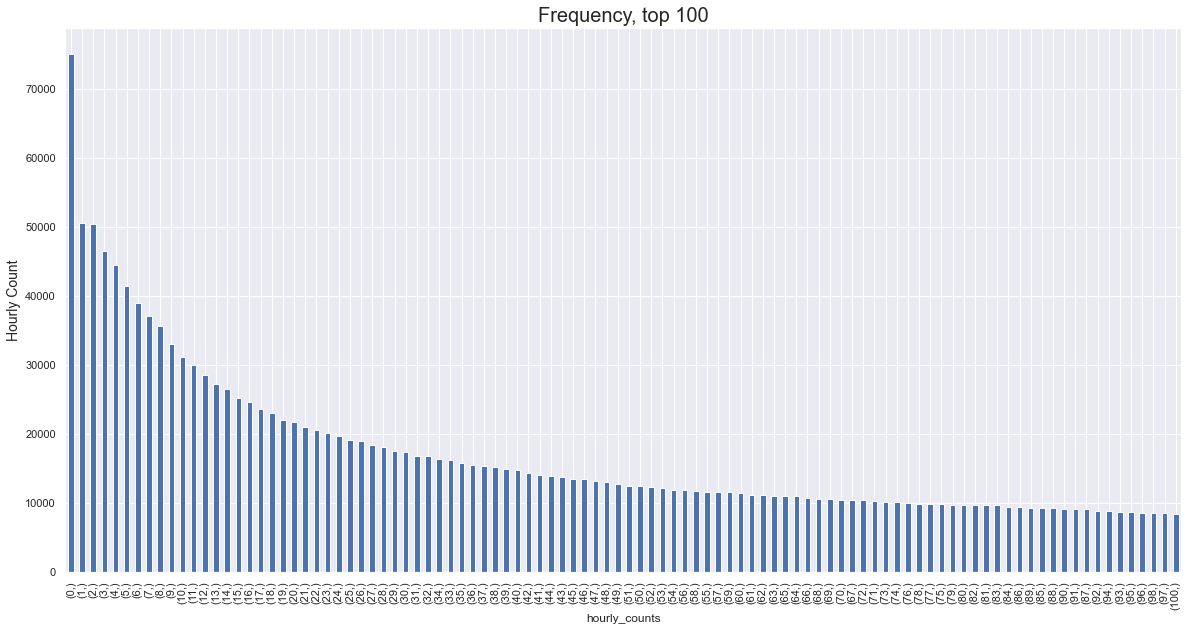

In [209]:
axs = rs[:100].plot.bar(figsize=(20, 10), rot = 90)
axs.set_title('Frequency, top 100', size=20)
axs.set_ylabel('Hourly Count', size=14)
plt.show()


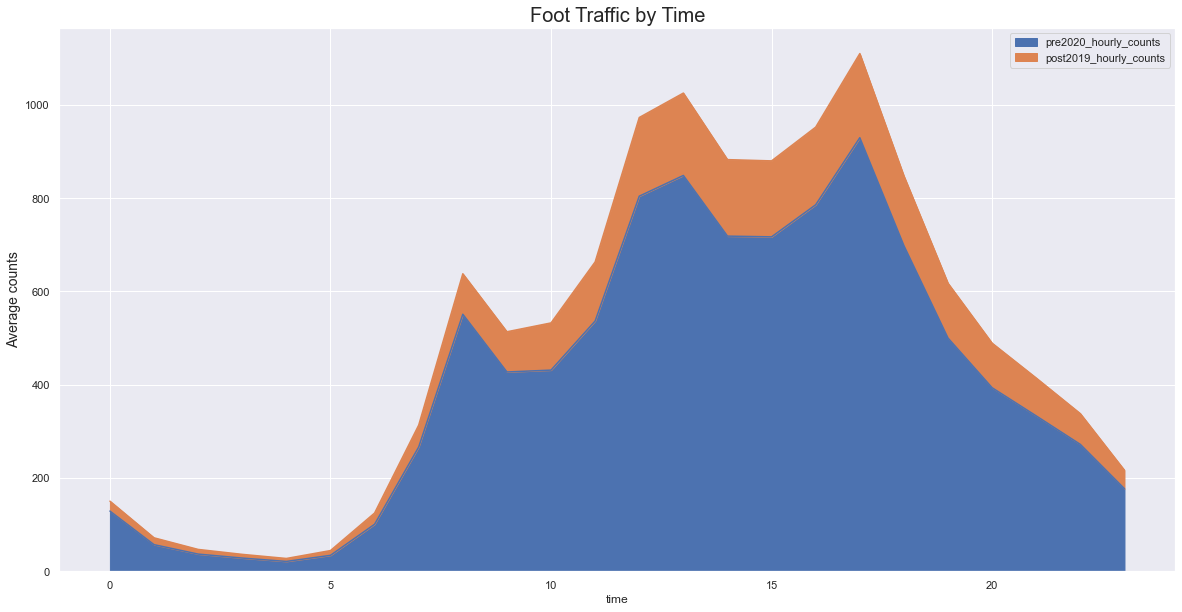

In [222]:
#examine pre Covid and post 2019 foot traffic
ds = pd.DataFrame(sensor_ds.groupby(["time"])["pre2020_hourly_counts","post2019_hourly_counts"].mean())
df = ds.sort_values(by=['time'])
axs = df.plot.area(figsize=(20, 10))
axs.set_title('Foot Traffic by Time', size=20)
axs.set_ylabel('Average counts', size=14)
plt.show()


## Examine Pedestrian Traffic by Weekday 

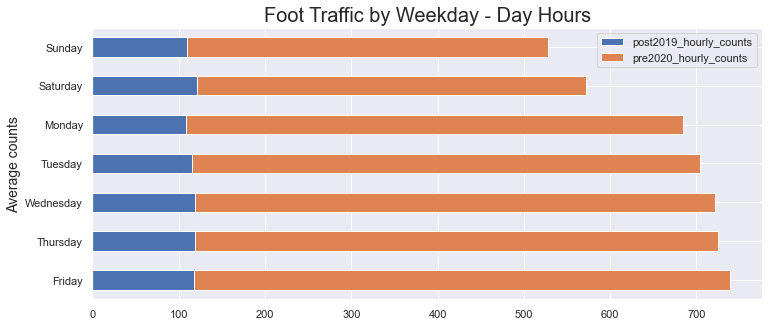

           post2019_hourly_counts  pre2020_hourly_counts
day                                                     
Friday                 118.037838             621.057157
Monday                 108.672732             575.217959
Saturday               121.193445             451.183935
Sunday                 109.023656             418.899238
Thursday               119.240018             606.327427
Tuesday                115.421740             588.282018
Wednesday              119.291492             602.673719


In [261]:
#distribution by traffic, by day - Covid impact on day
df_day['pre2020_hourly_counts'] = np.where(df_day['year']<=2019,df_day['hourly_counts'] , 0)
pivot = pd.pivot_table(df_day, values=["pre2020_hourly_counts","post2019_hourly_counts"], index=['day'], aggfunc=np.mean)
rs = pivot.sort_values(by='pre2020_hourly_counts', ascending = False)
axs =rs.plot.barh(figsize=(12, 5), stacked=True);

axs.set_title('Foot Traffic by Weekday - Day Hours', size=20)
axs.set_ylabel('Average counts', size=14)
plt.show()

print(pivot)


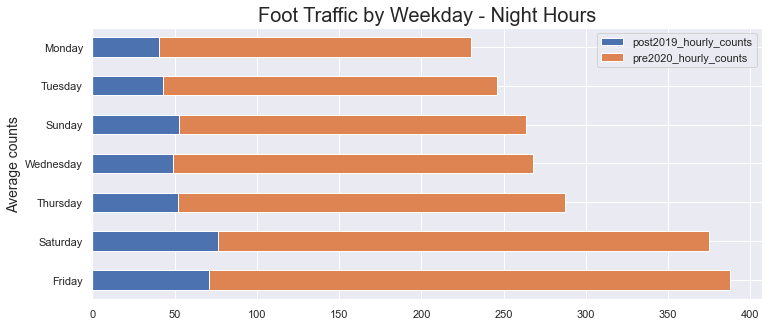

           post2019_hourly_counts  pre2020_hourly_counts
day                                                     
Friday                  70.742168             316.916047
Monday                  40.560096             189.703862
Saturday                76.157817             298.691270
Sunday                  52.664457             210.678895
Thursday                52.259859             235.018921
Tuesday                 43.002026             202.723255
Wednesday               49.214528             218.310429


In [260]:
#distribution by traffic, by night - Covid impact on night
df_night['pre2020_hourly_counts'] = np.where(df_night['year']<=2019,df_night['night_counts'] , 0)
pivot = pd.pivot_table(df_night, values=["pre2020_hourly_counts","post2019_hourly_counts"], index=['day'], aggfunc=np.mean)
rs = pivot.sort_values(by='pre2020_hourly_counts', ascending = False)
axs =rs.plot.barh(figsize=(12, 5), stacked=True);

axs.set_title('Foot Traffic by Weekday - Night Hours', size=20)
axs.set_ylabel('Average counts', size=14)
plt.show()

print(pivot)

## Examine Pedestrian Traffic by Day and Night

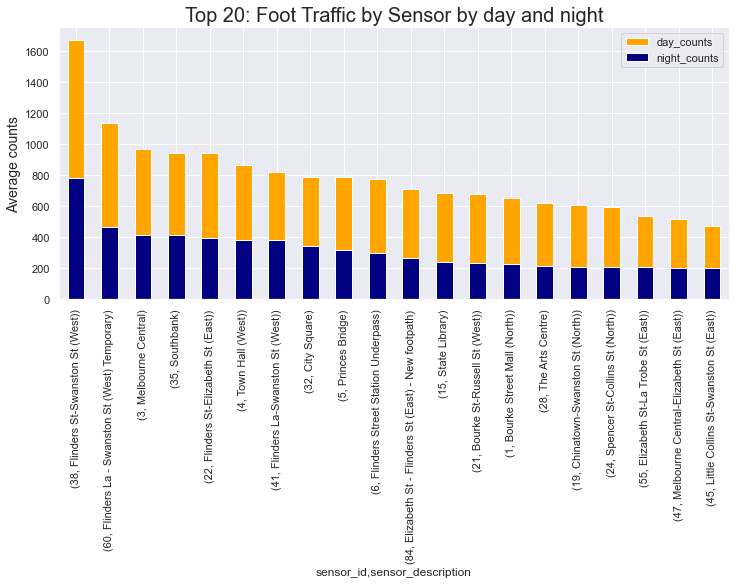

In [276]:
#distribution by traffic, by day
pivot = pd.pivot_table(sensor_ds, values='day_counts', index=['sensor_id','sensor_description'], aggfunc=np.mean)
pivot_ds = pivot['day_counts'].nlargest(n=20)
pivot_ds.plot.bar(figsize=(12, 5), color='orange', legend=True);

#by night
pivot = pd.pivot_table(sensor_ds, values='night_counts', index=['sensor_id','sensor_description'], aggfunc=np.mean)
pivot_ds = pivot['night_counts'].nlargest(n=20)
axs = pivot_ds.plot.bar(figsize=(12, 5), color='navy', legend=True);

axs.set_title('Top 20: Foot Traffic by Sensor by day and night', size=20)
axs.set_ylabel('Average counts', size=14)
plt.show()

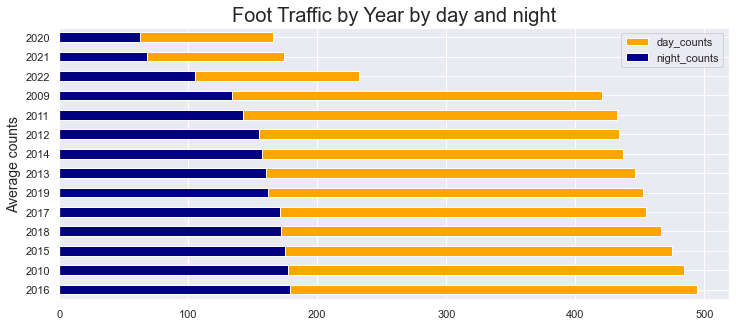

In [277]:
#distribution by traffic, by day
pivot = pd.DataFrame(pd.pivot_table(sensor_ds, values='day_counts', index=['year'], aggfunc=np.mean))
pivot_ds = pivot['day_counts'].nlargest(n=20)
pivot_ds.plot.barh(figsize=(12, 5), color='orange', legend=True);

#by night
pivot = pd.DataFrame(pd.pivot_table(sensor_ds, values='night_counts', index=['year'], aggfunc=np.mean))
pivot_ds = pivot['night_counts'].nlargest(n=20)
axs = pivot_ds.plot.barh(figsize=(12, 5), color='navy', legend=True);

axs.set_title('Foot Traffic by Year by day and night', size=20)
axs.set_ylabel('Average counts', size=14)
plt.show()

<p style="font-family: helvetica,arial,sans-serif; font-size:1.6em;color:white; background-color: black">&emsp;<b>References</b>

City of Melbourne Open Data Team, 2014 - 2021,'Pedestrian Counting System - Monthly (counts per hour)', City of Melbourne, date retrieved 11 Aug 2022, <https://dev.socrata.com/foundry/data.melbourne.vic.gov.au/b2ak-trbp>

City of Melbourne Open Data Team, 2014 - 2021,'Pedestrian Counting System - Sensor Locations', City of Melbourne, date retrieved 26 Aug 2022, <https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Sensor-Locations/h57g-5234>


    

In [ ]:
!jupyter nbconvert  eda_compare_pedestrian_traffic_precovid_to_now.ipynb --to html